### ordination to pull out fractions containing labeled OTUs

In [21]:
from pandas import DataFrame, get_dummies
import statsmodels.api as sm
from statsmodels.sandbox.regression.try_catdata import cat2dummy
from IPython.display import FileLink

In [22]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R
library(phyloseq)
library(vegan)
library(ggplot2)
library(foreach)
library(doParallel)
library(plyr)
library(gridExtra)
library(RColorBrewer)
library(lattice)

###First let's look at the <sup>13</sup>C cellulose versus control comparison. 

In [24]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.SS = prune_samples((physeq.md$Treatment %in% c("12CCSS","13CCSS"))& (physeq.md$Day == 30) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.SS.snorm = transform_sample_counts(physeq.SS, function(x) x/sum(x))
physeq.SS.thresh = filter_taxa(physeq.SS.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.SS)
print(physeq.SS.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1421 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1421 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1421 tips and 1420 internal nodes ]


### Calculate pairwise weighted unifrac distances between samples.

In [25]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.SS.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

###Ordinate using weighted unifrac distances with NMDS.

In [26]:
%%R
nmds = ordinate(physeq.SS.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.06235117 
Run 1 stress 0.1233754 
Run 2 stress 0.088832 
Run 3 stress 0.06404547 
Run 4 stress 0.1236107 
Run 5 stress 0.06261482 
... procrustes: rmse 0.004244552  max resid 0.0243654 
Run 6 stress 0.06333484 
Run 7 stress 0.1257097 
Run 8 stress 0.06333513 
Run 9 stress 0.06517795 
Run 10 stress 0.1238768 
Run 11 stress 0.08884758 
Run 12 stress 0.08705651 
Run 13 stress 0.08904191 
Run 14 stress 0.06517468 
Run 15 stress 0.1217137 
Run 16 stress 0.06549861 
Run 17 stress 0.06333595 
Run 18 stress 0.06517798 
Run 19 stress 0.1093648 
Run 20 stress 0.06386288 


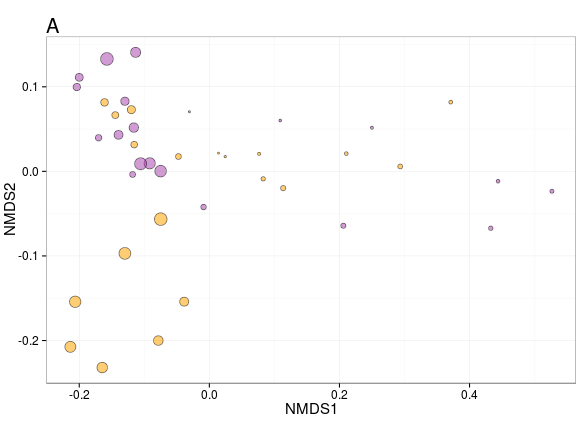

In [27]:
%%R -w 8 -h 6 -u in

colours = c("#ac4aaf","orange")

df = plot_ordination(physeq.SS.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12CCSS", "13CCSS"),
                            labels=c("Control", "Cellulose Only"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(legend.position = "none")
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = 0, size = 20))
p1 = p1 + theme(axis.title.x = element_text(size=15))
p1 = p1 + theme(axis.title.y = element_text(size=15))
p1 = p1 + theme(axis.text.x = element_text(size=12))
p1 = p1 + theme(axis.text.y = element_text(size=12))

p1

### Do the same for 13CCPS at D30

In [28]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PS = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& (physeq.md$Day == 30) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.PS.snorm = transform_sample_counts(physeq.PS, function(x) x/sum(x))
physeq.PS.thresh = filter_taxa(physeq.PS.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PS)
print(physeq.PS.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1022 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1022 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1022 tips and 1021 internal nodes ]


In [29]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.PS.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [30]:
%%R
nmds = ordinate(physeq.PS.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.05130933 
Run 1 stress 0.08376609 
Run 2 stress 0.04734696 
... New best solution
... procrustes: rmse 0.01553416  max resid 0.04953944 
Run 3 stress 0.04719288 
... New best solution
... procrustes: rmse 0.007981837  max resid 0.04441486 
Run 4 stress 0.07623967 
Run 5 stress 0.04719283 
... New best solution
... procrustes: rmse 0.0002084216  max resid 0.0008264791 
*** Solution reached


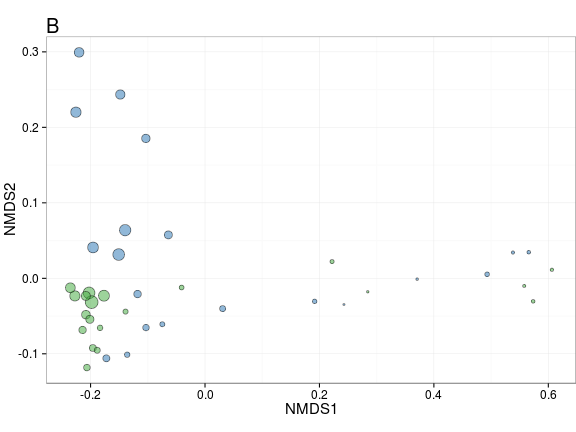

In [31]:
%%R -w 8 -h 6 -u in

colours = c("#4daf4a", "#377eb8")

df = plot_ordination(physeq.PS.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p2 = p2 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p2 = p2 + scale_fill_manual(values = colours,
                           breaks=c("12CCPS", "13CCPS"),
                            labels=c("Control", "C Mixture"))
p2 = p2 + guides(alpha = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
#p2 = p2 + guides(fill = guide_legend(override.aes = list(size = 4)))
#p2 = p2 + guides(size = guide_legend(override.aes = list(fill = "black")))
p2 = p2 + theme_bw()
p2 = p2 + theme(legend.position = "none")
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = 0, size = 20))
p2 = p2 + theme(axis.title.x = element_text(size=15))
p2 = p2 + theme(axis.title.y = element_text(size=15))
p2 = p2 + theme(axis.text.x = element_text(size=12))
p2 = p2 + theme(axis.text.y = element_text(size=12))

p2

### All treatments at D30

In [32]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.all = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS"))& (physeq.md$Day %in% c(30)) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.all.snorm = transform_sample_counts(physeq.all, function(x) x/sum(x))
physeq.all.thresh = filter_taxa(physeq.all.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.all)
print(physeq.all.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1220 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1220 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1220 tips and 1219 internal nodes ]


In [33]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.all.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [34]:
%%R
nmds = ordinate(physeq.all.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08691032 
Run 1 stress 0.1123127 
Run 2 stress 0.1007339 
Run 3 stress 0.09083074 
Run 4 stress 0.08694953 
... procrustes: rmse 0.002601076  max resid 0.01720554 
Run 5 stress 0.1053052 
Run 6 stress 0.08683202 
... New best solution
... procrustes: rmse 0.002792489  max resid 0.01453547 
Run 7 stress 0.1086053 
Run 8 stress 0.1001127 
Run 9 stress 0.1106262 
Run 10 stress 0.09154538 
Run 11 stress 0.08647394 
... New best solution
... procrustes: rmse 0.0118109  max resid 0.0793134 
Run 12 stress 0.08677688 
... procrustes: rmse 0.00434263  max resid 0.02599533 
Run 13 stress 0.09944559 
Run 14 stress 0.0864739 
... New best solution
... procrustes: rmse 0.0001432253  max resid 0.0007280659 
*** Solution reached


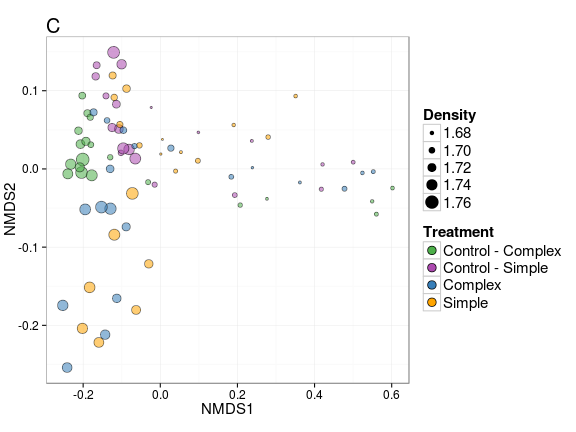

In [35]:
%%R -w 8 -h 6 -u in

colours = c("#4daf4a","#ac4aaf","#377eb8","orange")

df = plot_ordination(physeq.all.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p3 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p3 = p3 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p3 = p3 + scale_fill_manual(values = colours,
                            breaks=c("12CCPS", "12CCSS", "13CCPS", "13CCSS"),
                            labels=c("Control - Complex", "Control - Simple", 
                                     "Complex", "Simple"))
p3 = p3 + guides(alpha = FALSE)
p3 = p3 + scale_size_area(aesthetics = "Density")
p3 = p3 + ggtitle("C")
p3 = p3 + guides(fill = guide_legend(override.aes = list(size = 4)))
p3 = p3 + guides(size = guide_legend(override.aes = list(fill = "black")))
p3 = p3 + theme_bw()
p3 = p3 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p3 = p3 + theme(plot.title = element_text(hjust = 0, size = 20))
p3 = p3 + theme(axis.title.x = element_text(size=15))
p3 = p3 + theme(axis.title.y = element_text(size=15))
p3 = p3 + theme(axis.text.x = element_text(size=12))
p3 = p3 + theme(axis.text.y = element_text(size=12))
p3 = p3 + theme(legend.title = element_text(size = 15), legend.text = element_text(size = 15))

p3

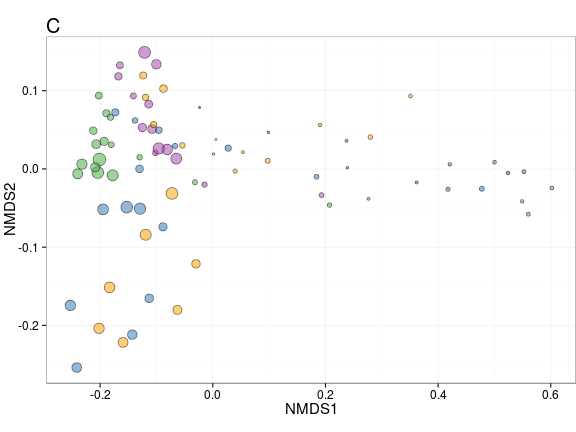

In [36]:
%%R -w 8 -h 6 -u in

p4 = p3 + theme(legend.position = "none")
p4

In [37]:
%%R
get_legend = function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

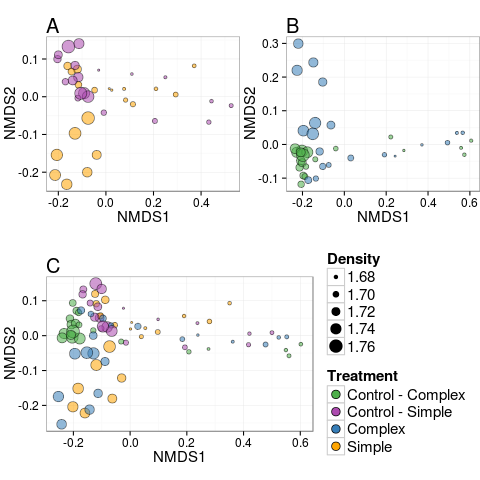

In [38]:
%%R

grid.newpage()
pushViewport(viewport(layout = grid.layout(20, 4)))
#vplayout = function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

define_region = function(row, col){
  viewport(layout.pos.row = row, layout.pos.col = col)
} 

#legend = ggplotGrob(p3)
#gp3 = ggplot_gtable(ggplot_build(p3))
#legend = ggplotGrob(gp3)
legend = get_legend(p3)
legend = editGrob(legend, vp = define_region(11:20, 4))

print(p1, vp = define_region(1:10, 1:2))
print(p2, vp = define_region(1:10, 3:4))
print(p3, vp = define_region(11:20, 1:4))
#grid.draw(legend)
#print(legend, vp = define_region(1:6, 5))

In [39]:
%%R
png("figs/ordination_allpanels.png", w = 10, h = 10, units = "in", res = 600)
pushViewport(viewport(layout = grid.layout(20, 4)))
print(p1, vp = define_region(1:10, 1:2))
print(p2, vp = define_region(1:10, 3:4))
print(p3, vp = define_region(11:20, 1:4))
#grid.draw(legend)
dev.off()

png 
  2 


In [40]:
FileLink("figs/ordination_allpanels.png")

/home/ashley/single_substrate/figs/ordination_allpanels.png